## Robustness Prediction with Gaussian Process Regression (GPR)
- INPUT: feature
- TARGET: robustness with STL
- STL rules:
1: Lane-observation (down, right)
2: Lane-observation (up, left)
3: Collision (front)
4: Collision (others)
5: Speed-limit
6: Slow-down

In [1]:
from __future__ import print_function, division, absolute_import

import math
import os
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, WhiteKernel, ConstantKernel

from core.SimScreenMatplotlib import SimScreenMatplotlib
from core.SimTrack import *
from core.TrainData import *
from src.utils_sim import *
from src.get_rgb import get_rgb

import matplotlib

### Step 1: Set Data

In [2]:
txt_pca = "_pcax"  # "_pcax", "_pcay", ""
alpha = 0.3
data_name = "us101"

if txt_pca == "_pcax" or txt_pca == "_pcay":
    use_pcadata = True
else:
    use_pcadata = False
use_pcadata_int = (use_pcadata == True)

directory2load = "./data_train/pca" if use_pcadata else "./data_train"

directory2save = "./trained_model/{:s}".format("gpr")
if not os.path.exists(directory2save):
    os.makedirs(directory2save)

filename2read = []
sample_ratio_data = []

if data_name == "us101":
    for nidx_d in range(1, 3):
        if use_pcadata:
            vehicle_data_filename_tmp = "{:s}/train_single{:s}_{:d}_us101_{:d}.npy".\
                format(directory2load, txt_pca, int(alpha * 10), nidx_d)
        else:
            vehicle_data_filename_tmp = "{:s}/train_single_highd_{:d}.npy".\
                format(directory2load, nidx_d)

        filename2read.append(vehicle_data_filename_tmp)
        sample_ratio_data += [1.0]
elif data_name == "highd":
    trackid_exclude = np.arange(5, 61, 5, dtype=np.int32)
    trackid_include = np.setdiff1d(np.arange(25, 61), trackid_exclude)
    for nidx_d in range(0, trackid_include.shape[0]):
        if use_pcadata:
            vehicle_data_filename_tmp = "{:s}/train_single{:s}_{:d}_highd_{:d}.npy".\
            format(directory2load, txt_pca, int(alpha * 10), trackid_include[nidx_d])
        else:
            vehicle_data_filename_tmp = "{:s}/train_single_highd_{:d}.npy".\
            format(directory2load, trackid_include[nidx_d])

        filename2read.append(vehicle_data_filename_tmp)
        sample_ratio_data += [0.75]
else:
    pass

use_x_sp, use_y_sp = False, False
num_train, num_test = 5000, 3000
h_prev_d, h_post_d = 1, 1
dim_p = 2

mode_f = 1
if mode_f == 1:
    idx_f_use = [6, 7, 8, 9, 10, 11]
elif mode_f == 2:
    idx_f_use = [3, 6, 7, 8, 9, 10, 11]
elif mode_f == 3:
    idx_f_use = [3, 6, 7, 8, 9, 10, 11, 18]
elif mode_f == 4:
    idx_f_use = [3, 6, 7, 8, 9, 10, 11, 20]
elif mode_f == 5:
    idx_f_use = [3, 6, 7, 8, 9, 10, 11, 18, 20]
else:
    idx_f_use = [6, 7, 8, 9, 10, 11]
    
dis_f = False
dim_f = len(idx_f_use)

idx_r_use = [0, 1, 2, 4, 5]
dim_r = len(idx_r_use)
    
traindata = TrainData(filename2read, sample_ratio_data, 0, 0, num_train, num_test, h_prev_d, h_post_d, 
                      dim_p, idx_f_use, idx_r_use, 1, use_x_sp=use_x_sp, use_y_sp=use_y_sp, dis_f=dis_f, 
                      load_multi=False)
traindata.processing()

# Set train-data & test-data
f_gpr = np.copy(traindata.f_train_n)
# r_gpr = np.copy(traindata.r_train_n)
r_gpr = np.copy(traindata.r_train)
r_gpr = np.reshape(r_gpr, (-1, dim_r))

f_gpr_test = np.copy(traindata.f_test_n)
r_gpr_test = np.copy(traindata.r_test)
r_gpr_test = np.reshape(r_gpr_test, (-1, dim_r))

f_mean, f_std = traindata.f_train_mean, traindata.f_train_std
r_mean, r_std = traindata.r_train_mean, traindata.r_train_std

# Set model-name
if use_pcadata:
    model_name = "gpr_{:s}_f{:d}r{:d}{:s}_{:d}_{:d}".\
        format(data_name, mode_f, dim_r, txt_pca, int(alpha*10), num_train)
else:
    model_name = "gpr_{:s}_f{:d}r{:d}_{:d}".\
        format(data_name,mode_f, dim_r, num_train)

print("[MODEL] {:s}".format(model_name))
print("[SET DATA] train-size: {:d}, test-size: {:d}".format(traindata.n_traindata, traindata.n_testdata))

data_size (before): 37837
data_size (after): 37837
[MODEL] gpr_us101_f1r5_pcax_3_5000
[SET DATA] train-size: 5000, test-size: 3000


### Step 2: Learn GPR

In [3]:
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel()

gpr = []
for nidx_d in range(0, dim_r):
    r_gpr_sel = r_gpr[:, nidx_d]
    r_gpr_sel = np.reshape(r_gpr_sel, (-1, 1))

    # Instantiate a Gaussian Process model
    gpr_tmp = GaussianProcessRegressor(kernel=kernel)

    # Fit to data using Maximum Likelihood Estimation of the parameters (for each dim)
    gpr_tmp.fit(f_gpr, r_gpr_sel)
    gpr.append(gpr_tmp)
    
    print("[TRAIN GPR-{:d}]".format(nidx_d))

[TRAIN GPR-0]
[TRAIN GPR-1]
[TRAIN GPR-2]
[TRAIN GPR-3]
[TRAIN GPR-4]


### Step 3: Show Error Histogram

In [4]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
r_gpr_pred = np.zeros((f_gpr_test.shape[0], dim_r), dtype=np.float32)
r_gpr_pred_std = np.zeros((f_gpr_test.shape[0], dim_r), dtype=np.float32)
for nidx_d in range(0, dim_r):
    gpr_sel = gpr[nidx_d]
    r_gpr_pred_tmp, r_gpr_pred_std_tmp = gpr_sel.predict(f_gpr_test, return_std=True)
    r_gpr_pred[:, nidx_d] = r_gpr_pred_tmp.reshape(-1)
    r_gpr_pred_std[:, nidx_d] = r_gpr_pred_std_tmp.reshape(-1)

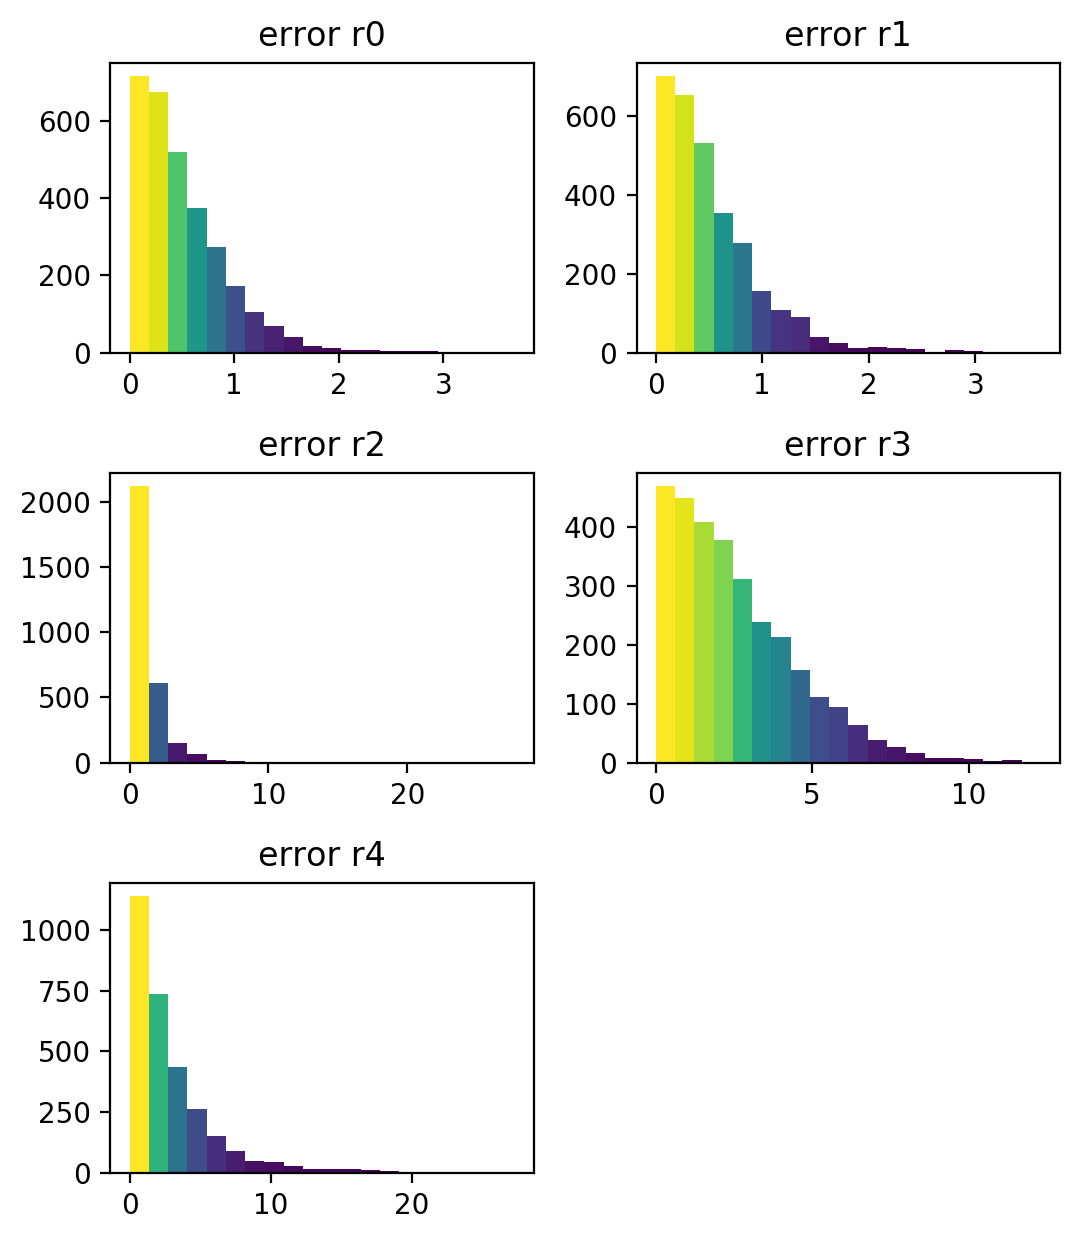

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

diff_r_test = r_gpr_pred - r_gpr_test
diff_abs = np.abs(diff_r_test)

plot_col = 2
plot_row = math.ceil(dim_r / plot_col)
fig1, axs1 = plt.subplots(plot_row, plot_col, figsize=(5.5, plot_row * 2.1), dpi=200, tight_layout=True)

for nidx_d in range(0, dim_r):
    idx_row = math.floor(nidx_d / 2)
    idx_col = nidx_d - idx_row * 2
    
    diff_abs_0 = diff_abs[:, nidx_d]
    N0, bins0, patches0 = axs1[idx_row, idx_col].hist(diff_abs_0, bins=20)
    fracs_hist0 = N0 / N0.max()
    norm0 = colors.Normalize(fracs_hist0.min(), fracs_hist0.max())
    for thisfrac0, thispatch0 in zip(fracs_hist0, patches0):
        color0 = plt.cm.viridis(norm0(thisfrac0))
        thispatch0.set_facecolor(color0)
    axs1[idx_row, idx_col].set_title('error r'+str(nidx_d))

axs1[-1, -1].axis('off')
    
plt.show()

filename2save_pic = "{:s}/{:s}.png".format(directory2save, model_name)
fig1.savefig(filename2save_pic, dpi=300)

### Step 4: Save Result

In [6]:
data2save = {'idx_f_use': idx_f_use, 'idx_r_use': idx_r_use, 'dis_f': dis_f, 
             'f_mean': f_mean, 'f_std': f_std, 'r_mean': r_mean, 'r_std': r_std,
             'f_gpr': f_gpr, 'r_gpr': r_gpr}

filename2save0 = "{:s}/p_{:s}".format(directory2save, model_name)
np.save(filename2save0, data2save)
print("SAVED-{:s}".format(filename2save0))

for nidx_d in range(0, dim_r):
    filename2save1 = "{:s}/{:s}_{:d}.pkl".format(directory2save, model_name, nidx_d)
    with open(filename2save1, 'wb') as file:
        pickle.dump(gpr[nidx_d], file)
    print("SAVED-{:s}".format(filename2save1))

SAVED-./trained_model/gpr/p_gpr_us101_f1r5_pcax_3_5000
SAVED-./trained_model/gpr/gpr_us101_f1r5_pcax_3_5000_0.pkl
SAVED-./trained_model/gpr/gpr_us101_f1r5_pcax_3_5000_1.pkl
SAVED-./trained_model/gpr/gpr_us101_f1r5_pcax_3_5000_2.pkl
SAVED-./trained_model/gpr/gpr_us101_f1r5_pcax_3_5000_3.pkl
SAVED-./trained_model/gpr/gpr_us101_f1r5_pcax_3_5000_4.pkl
